Architecture
- build the state graph.
- we need tools to:
- - download specie occurrence information from gbif
- - download temperature data from wordclim
  - apply a given model
  - display maps

# Import requirements

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
import os
from langchain.chat_models import init_chat_model
from IPython.display import Image, display
import getpass
from langchain_tavily import TavilySearch
from langchain_tavily import TavilySearch
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import ToolMessage
from langgraph.checkpoint.memory import InMemorySaver
import numpy as np
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import requests
import zipfile
import tempfile
from typing import List
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import requests
import pandas as pd
import geopandas as gpd
import pandas as pd
import elapid as ela
import os, zipfile, requests, io
from typing import Dict, Any
import rasterio.mask
from shapely.geometry import mapping
from sklearn.metrics import roc_auc_score
import os
import glob
import numpy as np
from shapely.geometry import mapping
import rioxarray as rxr
import geopandas as gpd
import os
import requests
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from typing import Dict, Any, Optional
import geodatasets

## Constants

In [10]:
# wordclim base url:
GADM_JSON_URL = "https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_{iso3}_{level}.json"
# gbfif base url:
GBIF_OCCURRENCE_URL = "https://api.gbif.org/v1/occurrence/search"
GBIF_API = "https://api.gbif.org/v1"

## Integrating Google Gemini

Utilize your own Gemini API key which can be obtained at: <a href="https://ai.google.dev/gemini-api/docs/api-key" target="_blank">https://ai.google.dev/gemini-api/docs/api-key</a>

In [ ]:
if not os.environ.get("GOOGLE_API_KEY"):
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("GEMINI API KEY:\n")

In [40]:
llm = init_chat_model("google_genai:gemini-2.0-flash")

## Integrating Tavili 
Tavily is a tool to enable llm to do researchs over the internet

In [41]:
if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API key:\n")

## Models Utility Functions

This blog contains utility function needed for all tools to work as expected

In [42]:
# Modeling utils
# ==========================================================
# Trait-Based Functions
# ==========================================================

def logan_fecundity(T, a=0.378, b=0.173, Tmax=40.0, c=2.97):
    F_T = a * np.exp(b * T) - np.exp(b * Tmax - ((Tmax - T) / c))
    F_T = np.where((T > Tmax) | (F_T < 0), 0, F_T)
    return F_T

def dev_rate_egg(T):   return max(0, -0.0009*T**2 + 0.048*T - 0.345)
def dev_rate_larva(T): return max(0, -0.0007*T**2 + 0.039*T - 0.32)
def dev_rate_pupa(T):  return max(0, -0.0005*T**2 + 0.026*T - 0.2)

def surv_rate_egg(T):   return 1.01 * np.exp(-0.5 * ((T - 24.5) / 4.8)**2)
def surv_rate_larva(T): return 0.95 * np.exp(-0.5 * ((T - 27) / 3.5)**2)
def surv_rate_pupa(T):  return 0.93 * np.exp(-0.5 * ((T - 26.8) / 3.8)**2)

def mort_rate_adult(T):
    base = 0.0207
    a = 0.000603
    return base + a * (T - 26)**2

def compute_suitability(T):
    if np.isnan(T) or np.isinf(T) or (T < 0) or (T > 50):
        return 0.0
    
    time_step = 6
    F  = logan_fecundity(T)
    dE = dev_rate_egg(T)
    dL = dev_rate_larva(T)
    dP = dev_rate_pupa(T)
    sE = surv_rate_egg(T)
    sL = surv_rate_larva(T)
    sP = surv_rate_pupa(T)
    muA = mort_rate_adult(T)
    
    M = np.array([
        [-dE,      0,       0,        F],
        [sE*dE,  -dL,      0,        0],
        [0,      sL*dL,   -dP,       0],
        [0,       0,      sP*dP,   -muA]
    ]) * time_step
    
    eigs = np.linalg.eigvals(M)
    lambda_max = np.max(np.real(eigs))
    return max(0, lambda_max)

compute_suitability_vec = np.vectorize(compute_suitability)

def epi_prob(x):
    return np.where(x <= 1, 0, 1 - 1/x)

In [43]:
def fast_extract_pixel_values(path, band_number, coordinates):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Raster not found: {path}")

    with rasterio.open(path) as src:
        if band_number < 1 or band_number > src.count:
            raise ValueError(f"Invalid band number {band_number}, raster has {src.count} bands.")

        band = src.read(band_number)  # 2D array
        nodata = src.nodata
        height, width = band.shape
        
        # safe per-band scale / offset handling
        scales = getattr(src, "scales", None)
        if scales and 1 <= band_number <= len(scales):
            scale = scales[band_number - 1] if scales[band_number - 1] is not None else 1.0
        else:
            scale = 1.0

        offsets = getattr(src, "offsets", None)
        if offsets and 1 <= band_number <= len(offsets):
            offset = offsets[band_number - 1] if offsets[band_number - 1] is not None else 0.0
        else:
            offset = 0.0

        # Convert (lon, lat) to (row, col) using list comprehension
        rows_cols = [src.index(lon, lat) for lon, lat in coordinates]
        rows = np.array([r for r, _ in rows_cols])
        cols = np.array([c for _, c in rows_cols])

        # Initialize with NaNs
        values = np.full(len(rows), np.nan)

        # Bounds check
        in_bounds = (
            (rows >= 0) & (rows < height) &
            (cols >= 0) & (cols < width)
        )

        valid_rows = rows[in_bounds]
        valid_cols = cols[in_bounds]

        # Extract values using NumPy advanced indexing
        # extracted = band[valid_rows, valid_cols]
        extracted = band[valid_rows.astype(int), valid_cols.astype(int)]

        if nodata is not None:
            extracted = np.where(extracted == nodata, np.nan, extracted)

        # Assign back to full array
        values[in_bounds] = extracted
        values_list = values.tolist()
        values_list = [(v * scale + offset) if v is not None else None for v in values_list] # apply scale and offset

    return values_list

In [44]:
# clipping rasters tu study area
def clip_rasters_to_study_area(
    input_folder: str = "data/environmental",
    output_folder: str = "data/clipped",
    mask_path: str = "data/study_area.geojson"
    ):

    KNOWN_MISSING_RASTER_CRS = None
    os.makedirs(output_folder, exist_ok=True)

    # Load mask once and dissolve to a single (multi)polygon for speed/stability
    mask_gdf = gpd.read_file(mask_path)
    mask_dissolved = mask_gdf.dissolve()    # single row
    mask_geom = mask_dissolved.geometry.values[0]       # (multi)polygon
    mask_geom_mapping = [mapping(mask_geom)]            # GeoJSON-like

    input_files = sorted(glob.glob(os.path.join(input_folder, "*.tif")))
    output_files = sorted(glob.glob(os.path.join(output_folder, "*.tif")))

    for input_file in input_files:
        file_name = os.path.basename(input_file)
        out_path = os.path.join(output_folder, file_name)
        if out_path in sorted(output_files):
            print(f"Skipping already processed file: {file_name}")
            continue
    
        # Lazy read (helps with large rasters)
        r = rxr.open_rasterio(input_file, masked=True)
    
        # — Preference 1: Vector → Raster CRS when raster has CRS —
        if r.rio.crs is not None: # pyright: ignore[reportAttributeAccessIssue]
            # Reproject vector to raster CRS if needed
            if mask_gdf.crs != r.rio.crs: # pyright: ignore[reportAttributeAccessIssue]
                mask_for_this = mask_dissolved.to_crs(r.rio.crs) # pyright: ignore[reportAttributeAccessIssue]
                mask_mapping = [mapping(mask_for_this.geometry.values[0])]
            else:
                mask_mapping = mask_geom_mapping
    
            # Clip and write
            clipped = r.rio.clip(mask_mapping, r.rio.crs) # pyright: ignore[reportAttributeAccessIssue]
        
        else:
            # — Preference 2: Raster → Vector CRS when raster is missing a CRS —
            # Decide what CRS to stamp on the raster so we can operate safely
            crs_to_write = KNOWN_MISSING_RASTER_CRS or mask_gdf.crs
            if crs_to_write is None:
                raise ValueError(
                    f"No CRS on raster and vector has no CRS either for {file_name}. "
                    "Please specify KNOWN_MISSING_RASTER_CRS."
                )
    
            # Stamp CRS (this does NOT reproject; it declares what the raster already is)
            r = r.rio.write_crs(crs_to_write) # pyright: ignore[reportAttributeAccessIssue]
    
            # Make sure mask is in the same CRS (usually it already is)
            if mask_gdf.crs != r.rio.crs:
                mask_for_this = mask_dissolved.to_crs(r.rio.crs)
                mask_mapping = [mapping(mask_for_this.geometry.values[0])]
            else:
                mask_mapping = mask_geom_mapping
    
            try:
                clipped = r.rio.clip(mask_mapping, r.rio.crs)
            except Exception as e:
                print(f"Skip (no overlap or clip error): {file_name} -> {e}")
                continue
    
    
        # Decide dtype & predictor based on the actual array dtype
        is_float = np.issubdtype(clipped.dtype, np.floating)
    
        if is_float:
            # ensure a float nodata and float32 dtype (so PREDICTOR=3 is allowed)
            if clipped.rio.nodata is None or not np.isnan(clipped.rio.nodata):
                clipped = clipped.rio.write_nodata(np.nan)
            if clipped.dtype != np.float32:
                clipped = clipped.astype("float32")
            pred = 3
            out_dtype = "float32"
        else:
            # integer path: ensure integer nodata and PREDICTOR=2
            pred = 2
            nd = clipped.rio.nodata
            # choose a safe integer nodata compatible with the dtype range
            if nd is None or isinstance(nd, float):
                if clipped.dtype == np.int16:
                    nd_value = -32768
                elif clipped.dtype == np.int32:
                    nd_value = -2147483648
                elif clipped.dtype == np.uint16:
                    nd_value = 0
                elif clipped.dtype == np.uint8:
                    nd_value = 0
                else:
                    # generic fallback
                    nd_value = -9999
                clipped = clipped.rio.write_nodata(nd_value)
            out_dtype = str(clipped.dtype)
    
        # Write with explicit dtype & matching predictor
        clipped.rio.to_raster(
            out_path,
            dtype=out_dtype,          # <- force GDAL to use the dtype we intend
            compress="deflate",
            predictor=pred,           # 3 only with float32/64; 2 for integers
            zlevel=6,
            tiled=True,
            BIGTIFF="IF_SAFER",
        )
    
    
        print(f"Processed: {file_name}")
        output_files.append(out_path)  # avoid re-processing if rerun
        
        # close any open raster handle, if present
        try:
            r.close() # pyright: ignore[reportAttributeAccessIssue]
        except Exception:
            pass
    
        # delete names without risking NameError
        try:
            del clipped, r
        except NameError:
            pass


In [45]:
# GBIF Utils

def get_taxon_key(species_name: str) -> int:
    """Get GBIF taxonKey for a species name"""
    url = f"{GBIF_API}/species/match"
    r = requests.get(url, params={"name": species_name})
    r.raise_for_status()
    data = r.json()
    if "usageKey" not in data:
        raise ValueError(f"Species {species_name} not found in GBIF")
    return data["usageKey"]


def define_study_area(countries: List[str], output_path:str = "./data/study_area.geojson"):
    world_shp = gpd.read_file('world-administrative-boundaries.geojson')
    study_area_shp = world_shp[world_shp['name'].isin(countries)]
    print(study_area_shp)
    print(study_area_shp.is_empty.sum(), "empty geometries")
    if study_area_shp.crs is None:
        study_area_shp = study_area_shp.set_crs("EPSG:4326")
    study_area_shp = study_area_shp[~study_area_shp.geometry.is_empty]
    # Save to GeoJSON
    study_area_shp.to_file(output_path, driver="GeoJSON")
    study_area_shp.plot()
    return output_path

## AI Tools definition

In [46]:
# Define tool: download WorldClim temperature rasters
@tool
def download_worldclim_temp(period: str, resolution: str = "10m", out_dir: str = "./data") -> List[str]:
    """
    Download WorldClim temperature rasters for a given period.
    
    Args:
        period (str): "monthly", "annual", "bioclim", or "elevation".
        resolution (str): Spatial resolution ("10m", "5m", "2.5m", "30s").
        out_dir (str): Directory to save the rasters.
    
    Returns:
        List[str]: Paths to the downloaded raster files.
    """
    base_url = "https://geodata.ucdavis.edu/climate/worldclim/2_1/base"
    
    if period == "monthly":
        file_name = f"wc2.1_{resolution}_tavg.zip"
    elif period == "annual":
        file_name = f"wc2.1_{resolution}_tavg_ann.zip"
    elif period == "bioclim":
        file_name = f"wc2.1_{resolution}_bio.zip"
    elif period == "elevation":
        file_name = f"wc2.1_{resolution}_elev.zip"
    else:
        raise ValueError("Invalid period. Choose from 'monthly', 'annual', 'bioclim', 'elevation'.")

    url = f"{base_url}/{file_name}"
    os.makedirs(out_dir, exist_ok=True)
    local_zip = os.path.join(out_dir, file_name)
    
    # Download
    print(f"Downloading {url} ...")
    r = requests.get(url, stream=True)
    r.raise_for_status()
    with open(local_zip, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

    # Extract
    with zipfile.ZipFile(local_zip, "r") as zip_ref:
        zip_ref.extractall(out_dir)

    # Collect GeoTIFFs
    tifs = [os.path.join(out_dir, f) for f in os.listdir(out_dir) if f.endswith(".tif")]
    
    return tifs


In [47]:
# gbif data download tool
@tool
def download_gbif_occurrences(
        species: str,
        country: Optional[str] = None,
        limit: int = 500,
        n_absences: Optional[int] = None,
        output_dir: str = "./data/gbif_data"
    ) -> Dict[str, Any]:
    """
    Download species occurrence records from GBIF, add presence & pseudo-absence points,
    and save to CSV.

    Args:
        species: Scientific name of the species (e.g., "Papio anubis").
        country: Optional 2-letter ISO country code (e.g., "KE" for Kenya). If None, fetch global data.
        limit: Number of presence records to fetch (max 300,000 via paging).
        n_absences: Number of pseudo-absence/background points to generate. 
                    If None, defaults to same as presence count.
        output_dir: Directory where the CSV will be stored.

    Returns:
        A dictionary with the path to the saved CSV file and the number of records.
    """
    os.makedirs(output_dir, exist_ok=True)

    # -----------------------------
    # Fetch PRESENCE data from GBIF
    # -----------------------------
    records = []
    offset = 0
    batch_size = 300  # GBIF max per request

    while offset < limit:
        params = {
            "scientificName": species,
            "limit": min(batch_size, limit - offset),
            "offset": offset,
            "hasGeospatialIssue": False,
            "hasCoordinate": True
        }
        if country:
            params["country"] = country.upper()

        url = "https://api.gbif.org/v1/occurrence/search"
        response = requests.get(url, params=params)
        if response.status_code != 200:
            raise RuntimeError(f"GBIF request failed: {response.status_code}")

        data = response.json()
        results = data.get("results", [])
        if not results:
            break

        for r in results:
            if r.get("decimalLatitude") and r.get("decimalLongitude"):
                records.append({
                    "species": r.get("species"),
                    "lat": r.get("decimalLatitude"),
                    "lon": r.get("decimalLongitude"),
                    "country": r.get("country"),
                    "eventDate": r.get("eventDate"),
                    "basisOfRecord": r.get("basisOfRecord"),
                    "presence": 1
                })

        offset += batch_size

    if not records:
        raise ValueError(f"No records found for {species} (country={country})")

    df = pd.DataFrame(records)

    # -----------------------------
    # Generate ABSENCE (background) data
    # -----------------------------
    if n_absences is None:
        n_absences = len(df)


    if country:
        NE_URL = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
        world = gpd.read_file(NE_URL)
        geom = world[world["ISO_A2"] == country.upper()].geometry.values[0]
    else:
        # Global bounding box
        world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
        geom = world.unary_union  # all countries merged

    absences = []
    minx, miny, maxx, maxy = geom.bounds
    while len(absences) < n_absences:
        rand_x = np.random.uniform(minx, maxx)
        rand_y = np.random.uniform(miny, maxy)
        pt = Point(rand_x, rand_y)
        if geom.contains(pt):
            absences.append({"species": species, "lat": rand_y, "lon": rand_x,
                             "country": country or "GLOBAL",
                             "eventDate": None,
                             "basisOfRecord": "pseudoAbsence",
                             "presence": 0})

    df_abs = pd.DataFrame(absences)

    # -----------------------------
    # Combine presence + absence
    # -----------------------------
    df_all = pd.concat([df, df_abs], ignore_index=True)

    # Save to CSV
    out_csv = os.path.join(output_dir, f"{species.replace(' ', '_')}_{country or 'WORLD'}_with_absences.csv")
    df_all.to_csv(out_csv, index=False)

    return {"csv_path": out_csv, "records": len(df_all), "presence": len(df), "absences": len(df_abs)}


In [48]:
# download shapefiles
@tool
def download_shapefile(
        iso3: str,
        level: int = 0,
        output_dir: str = "./data/shapefiles"
    ):
    """
    Download and save GADM boundaries as GeoJSON.
    
    Args:
        iso3: ISO3 country code (e.g., "KEN").
        level: Administrative level (0 = country, 1 = provinces, 2 = districts, etc.)
        output_dir: Directory where the GeoJSON will be stored.
    """
    os.makedirs(output_dir, exist_ok=True)

    url = GADM_JSON_URL.format(iso3=iso3.upper(), level=level)
    response = requests.get(url)
    if response.status_code != 200:
        raise RuntimeError(f"Failed to download GADM JSON for {iso3} at level {level}")

    out_path = os.path.join(output_dir, f"gadm41_{iso3.upper()}_{level}.json")
    with open(out_path, "wb") as f:
        f.write(response.content)

    # Validate with GeoPandas
    try:
        gdf = gpd.read_file(out_path)
    except Exception as e:
        raise ValueError(f"Downloaded file is not a valid GeoJSON: {e}")

    return {"shapefile": out_path, "features": len(gdf)}


In [49]:
# suitability model tool
@tool
def run_suitability_model(temp_rast_path: str, output_path: str) -> str:
    """Compute suitability from a temperature raster using the Logan model
    and epidemic probability normalization. Saves and displays the result."""
    # Load raster
    with rasterio.open(temp_rast_path) as src:
        temp_rast = src.read(1)
        profile = src.profile

    # Replace NaN with 0
    temp_rast = np.where(np.isnan(temp_rast), 0, temp_rast)

    # Compute suitability
    lambda_raster = compute_suitability_vec(temp_rast)
    lambda_norm_raster = epi_prob(lambda_raster)

    # Save output raster
    profile.update(dtype=rasterio.float32, count=1, compress='lzw')
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(lambda_norm_raster.astype(np.float32), 1)

    # Plot
    plt.figure(figsize=(8, 6))
    im = plt.imshow(lambda_norm_raster, cmap="viridis")
    plt.title("Normalized Epidemic Probability (λmax)")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.show()

    return output_path

In [50]:
# niche modeling tool
@tool
def run_ecological_niche_model(
        species_name: str,
        occurrence_data_path: str,
        environmental_data_path: str,
        output_raster_path: str,
        bio_predictors: List[int] = [1,2,3],
        elevation: bool = True,
        resolution: str = "10m",
        study_area: List[str] = ['Kenya']
    ) -> str:
    """
    Trains a Maxent ecological niche model and applies it to environmental rasters
    for a specified species.

    Args:
        species_name: The name of the species to model (e.g., 'Busseola_fusca').
                      This is used to identify the correct column in the occurrence data.
        occurrence_data_path: Path to the CSV file with species occurrence and background data.
        environmental_data_path: Path to the folder containing environmental raster files.
        output_raster_path: Path to save the output GeoTIFF raster.
        bio_predictors: List of Bioclim variable id to include, a number between 1 and 19.
        elevation: boolean to specify if we should include or not elevation in the modeling.
        resolution (str): Spatial resolution ("10m", "5m", "2.5m", "30s").
        study_area: List of countries names ['Cameroon', 'Kenya'] for instance
    Returns:
        Path to the output
    """

    # -----------------------------
    # Load occurrence/background data
    # -----------------------------
    df_occ = pd.read_csv(occurrence_data_path)
    df_occ = df_occ.dropna(subset=["lon", "lat"])  # must have coords
    
    species_presence_column = "presence"
    occurrence_data = df_occ[df_occ[species_presence_column] == 1].copy()
    background_data = df_occ[df_occ[species_presence_column] == 0].copy()

    # Coordinates for raster extraction
    coordinates = list(zip(occurrence_data["lon"], occurrence_data["lat"]))
    band_number = 1

    # -----------------------------
    # Define predictors
    # -----------------------------
    predictors = [f"{resolution}_bio_{i}" for i in bio_predictors]
    if elevation:
        predictors.append(f"{resolution}_elev")
        
    # -----------------------------
    # Clip rasters to study area
    # -----------------------------
    define_study_area(countries=study_area)
    clipped_data_folder = "./data/clipped"
    clip_rasters_to_study_area(
        input_folder=environmental_data_path,
        output_folder=clipped_data_folder,
        mask_path="./data/study_area.geojson"
    )

    # -----------------------------
    # Extract raster values
    # -----------------------------
    for file in sorted(os.listdir(clipped_data_folder)):
        if not file.endswith(".tif"):
            continue
        file_path = os.path.join(clipped_data_folder, file)
        filename, _ = os.path.splitext(file)
        for predictor in predictors:
            if predictor in filename:
                # safe assignment
                occurrence_data.loc[:, predictor] = fast_extract_pixel_values(file_path, band_number, coordinates)
                background_data.loc[:, predictor] = fast_extract_pixel_values(file_path, band_number, coordinates)

    occurrence_points = occurrence_data[predictors]
    background_points = background_data[predictors]

    # print("### OCCURRENCE POINTS ###")
    # print(occurrence_points)

    # print("### BACKGROUND POINTS ###")
    # print(background_points)

    X = pd.concat([occurrence_points, background_points], ignore_index=True)
    y = pd.Series([1] * len(occurrence_points) + [0] * len(background_points))

    # -----------------------------
    # Handle NaNs in predictors
    # -----------------------------
    # print(f"Initial training set size: {X.shape}")

    mask = ~X.isna().any(axis=1)
    X_clean = X[mask]
    y_clean = y[mask]
    # print(f"After dropping NaNs: {X_clean.shape}")

    if X_clean.empty:
        from sklearn.impute import SimpleImputer
        # print("⚠️ All training rows had NaNs. Falling back to imputation...")
        imputer = SimpleImputer(strategy="mean")
        X_clean = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
        y_clean = y
        if X_clean.empty:
            raise ValueError("No valid samples remain after NaN handling. "
                             "Check that your study area overlaps with raster coverage.")

    # -----------------------------
    # Train Maxent model
    # -----------------------------
    maxent_model = ela.MaxentModel()
    maxent_model.fit(X_clean, y_clean)

    # -----------------------------
    # Apply model to rasters
    # -----------------------------
    rasters = [os.path.join(clipped_data_folder, f"wc2.1_{p}.tif") for p in predictors]
    os.makedirs(os.path.dirname(output_raster_path), exist_ok=True)
    ela.apply_model_to_rasters(maxent_model, rasters, output_raster_path)

    # -----------------------------
    # Plot result
    # -----------------------------
    with rasterio.open(output_raster_path) as src:
        raster_data = src.read(1).astype(float)
        raster_data[raster_data == src.nodata] = np.nan  # mask NoData

    plt.figure(figsize=(8, 6))
    im = plt.imshow(raster_data, cmap="viridis")
    plt.colorbar(im, fraction=0.046, pad=0.04, label="Suitability")
    plt.title(f"Ecological Niche Model - {species_name}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

    return output_raster_path


## Tools integration to the Agentic System State Graph

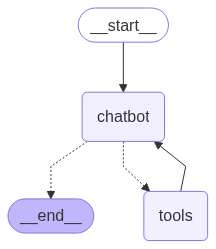

In [51]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# utilities
def display_graph(graph: StateGraph):
    try:
        display(Image(graph.get_graph().draw_mermaid_png()))
    except Exception:
        # This requires some extra dependencies and is optional
        pass

# tools
websearch_tool = TavilySearch(max_results=2)


tools = [
    websearch_tool, 
    download_worldclim_temp, 
    run_suitability_model, 
    run_ecological_niche_model,
    download_gbif_occurrences,
    download_shapefile
]


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)


def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# Nodes
llm_with_tools = llm.bind_tools(tools)

# for chat node
def chatbot_node(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# Edges
# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)

# add memory:
memory = InMemorySaver()

# build graph
graph_builder.add_node("chatbot", chatbot_node)
# graph_builder.add_node("wordclim_agent", wordclim_agent_node)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
# graph_builder.add_edge(START, "wordclim_agent")
# graph_builder.add_edge("wordclim_agent", END)
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile(checkpointer=memory)
display_graph(graph)


In [52]:
# run chatbot with memory
def ask_question(question: str, config: dict = {"configurable": {"thread_id": "1"}}):
    events = graph.stream(
        {"messages": [{"role": "user", "content": question}]},
        config,
        stream_mode="values",
    )
    for event in events:
        event["messages"][-1].pretty_print()

================================ Human Message =================================


    For the following instructions, use tools outputs to get full file paths
    Download bioclim from worldclim with 10m resolution and save in ./data/environmental
    Download Elevation data with 10m resolution and save in ./data/environmental
    Download the Ethiopia shapefiles and save in ./data/shapefiles/
    Download 300 records of Apis mellifera occurrences in Ethiopia from GBIF and save in ./data/gbif_data/
    And run an ecological niche model using the downloaded occurrence data, bioclimatic 1, 6 and 8 with elevation data in ethiopia
    
    Save results in /home/void/Documents/research/climate_modeling/data/outputs
================================== Ai Message ==================================
Tool Calls:
  download_worldclim_temp (166cd7d8-240d-4754-a1cf-71a8abf95596)
 Call ID: 166cd7d8-240d-4754-a1cf-71a8abf95596
  Args:
    resolution: 10m
    period: bioclim
    out_dir: ./data/enviro

/home/void/anaconda3/lib/python3.12/site-packages/elapid/features.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.drop(["geometry"], axis=1, errors="ignore", inplace=True)


Window:   0%|                              | 0/1 [00:00<?, ?it/s]

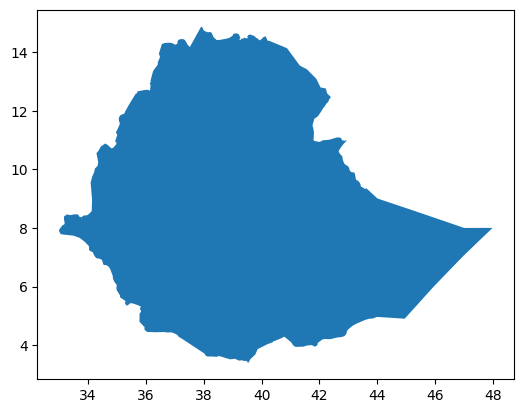

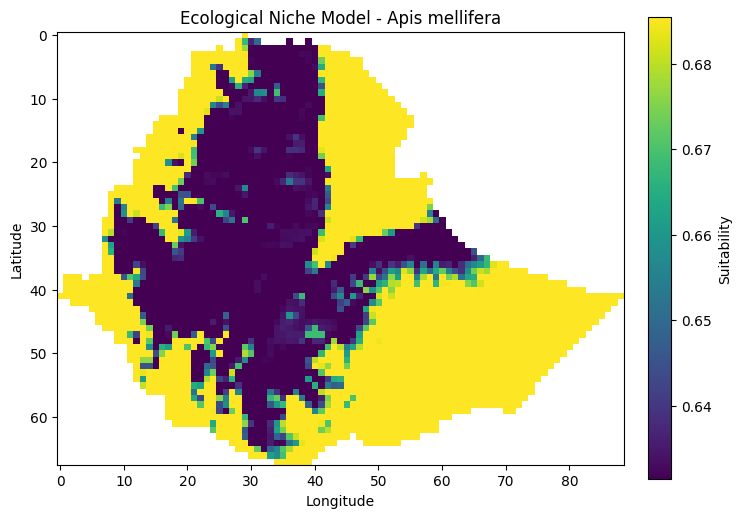

================================= Tool Message =================================
Name: run_ecological_niche_model

"/home/void/Documents/research/climate_modeling/data/outputs/Apis_mellifera_suitability.tif"
================================== Ai Message ==================================

I have downloaded the bioclim and elevation data from WorldClim, the Ethiopia shapefiles, and the Apis mellifera occurrence data from GBIF. I have also run the ecological niche model using the downloaded data and saved the results to /home/void/Documents/research/climate_modeling/data/outputs/Apis_mellifera_suitability.tif.


In [53]:
q1 = """
    For the following instructions, use tools outputs to get full file paths
    Download bioclim from worldclim with 10m resolution and save in ./data/environmental
    Download Elevation data with 10m resolution and save in ./data/environmental
    Download the Ethiopia shapefiles and save in ./data/shapefiles/
    Download 300 records of Apis mellifera occurrences in Ethiopia from GBIF and save in ./data/gbif_data/
    And run an ecological niche model using the downloaded occurrence data, bioclimatic 1, 6 and 8 with elevation data in ethiopia
    
    Save results in /home/void/Documents/research/climate_modeling/data/outputs"""

user_input = q1
ask_question(user_input)